In [1]:
import numpy as np
import pandas as pd

In [2]:
import pickle
import os
from datetime import datetime

In [3]:
# Khởi tạo tham số cho mô hình
# Chi phí kho
O = 50.0 # Chi phí đặt hàng
h_year = 10.0 # Chi phí lưu trữ (10 đô cho 1 sản phẩm / năm)
b = 20.0 # Chi phí thiếu hàng (20 đô cho 1 mỗi sản phẩm tồn đọng)
LT = 1 # Lead Time = 1 ngày (đơn hàng được đặt hôm nay sẽ đến vào ngày kế tiếp)
days_per_year = 365 # Số ngày trong một năm
h = h_year/days_per_year # Chi phí lưu trữ quy đổi theo ngày
q = 6 # Số lượng đặt hàng mỗi lần
r = 3 # Mức tồn kho đặt hàng lại (reorder point)

# Nhu cầu
mu = 3.0        # Nhu cầu trung bình mỗi ngày
sigma = 1.0     # Độ lệch chuẩn của nhu cầu

# ═══════════════════════════════════════════════════════
# ⚙️ Tham số của Q-learning (ĐÃ CẢI THIỆN & SỬA LỖI #3)
# ═══════════════════════════════════════════════════════

# Learning rate (✅ GIỮ NGUYÊN 0.2)
alpha = 0.5  # Tốc độ học (0.2 ổn định)

# Discount factor (✅ GIỮ NGUYÊN 0.95)
gamma = 0.5  # Hệ số chiết khấu (0.95 cho long-term planning)

# 🔥 Epsilon Decay Strategy (✅ GIẢM CHẬM HƠN: decay 0.995→0.998)
epsilon_start = 0.3      # Khám phá nhiều ở đầu (30%)
epsilon_end = 0.01       # Khai thác nhiều ở cuối (1%)
epsilon_decay = 0.998    # Giảm chậm hơn để explore kỹ

# Training (✅ GẤP ĐÔI episodes: 1000→2000)
num_episodes = 1000      # ✅ TĂNG để học kỹ hơn
episode_length = 300     # mỗi chu kỳ = 300 ngày

# 📊 Reward normalization scale
REWARD_SCALE = 100.0     # Chia reward cho 100

print("⚙️ Tham số Q-Learning (Đã tối ưu - LẦN 3 - FINAL):")
print(f"   - Alpha (learning rate):   {alpha}")
print(f"   - Gamma (discount factor): {gamma}")
print(f"   - Epsilon decay:           {epsilon_start} → {epsilon_end} (decay={epsilon_decay})")
print(f"   - Reward scale factor:     /{REWARD_SCALE:.0f}")
print(f"   - Episode length:          {episode_length} days")
print(f"   - Num episodes:            {num_episodes} ✅ GẤP ĐÔI để hội tụ tốt hơn")
print(f"   - Episodes × Days:         {num_episodes} × {episode_length} = {num_episodes * episode_length:,} steps")

⚙️ Tham số Q-Learning (Đã tối ưu - LẦN 3 - FINAL):
   - Alpha (learning rate):   0.5
   - Gamma (discount factor): 0.5
   - Epsilon decay:           0.3 → 0.01 (decay=0.998)
   - Reward scale factor:     /100
   - Episode length:          300 days
   - Num episodes:            1000 ✅ GẤP ĐÔI để hội tụ tốt hơn
   - Episodes × Days:         1000 × 300 = 300,000 steps


In [4]:
# Load Q-table và metadata từ file
def load_model(filename="models/q_table_inventory.pkl"):
    """
    Load Q-table và các thông tin đã lưu
    
    Returns:
    --------
    model_data : dict
        Dictionary chứa Q_table, params, training_info, states, actions
    """
    if not os.path.exists(filename):
        print(f"⚠️ File {filename} không tồn tại!")
        print("   → Bạn cần train model mới trước.")
        return None
    
    with open(filename, 'rb') as f:
        model_data = pickle.load(f)
    
    print(f"✅ Đã load model từ: {filename}")
    print(f"   - Q-table shape: {model_data['Q_table'].shape}")
    print(f"   - Training date: {model_data['training_info']['timestamp']}")
    print(f"   - Final avg cost: {model_data['training_info']['final_avg_cost']:.2f} €/episode")
    
    # Hiển thị epsilon strategy
    if 'epsilon_start' in model_data['training_info']:
        print(f"   - Epsilon decay: {model_data['training_info']['epsilon_start']:.3f} → "
              f"{model_data['training_info']['epsilon_end']:.3f}")
    
    print(f"   - Hyperparameters: alpha={model_data['params']['alpha']}, gamma={model_data['params']['gamma']}")
    
    return model_data


# ⚙️ Thử load model đã lưu (nếu có)
USE_PRETRAINED = False  # 🔴 ĐỔI THÀNH False ĐỂ TRAIN LẦN ĐẦU

if USE_PRETRAINED:
    loaded_model = load_model("models/q_table_inventory.pkl")
    
    if loaded_model is not None:
        # Restore Q-table và parameters
        Q = loaded_model['Q_table']
        states = loaded_model['states']
        actions = loaded_model['actions']
        min_IP = loaded_model['min_IP']
        max_IP = loaded_model['max_IP']
        
        # Restore hyperparameters
        params = loaded_model['params']
        alpha = params['alpha']
        gamma = params['gamma']
        
        # 🔥 Restore epsilon parameters
        if 'epsilon_start' in params:
            epsilon_start = params['epsilon_start']
            epsilon_end = params['epsilon_end']
            epsilon_decay = params['epsilon_decay']
        else:
            # Fallback cho model cũ
            epsilon_start = params.get('epsilon', 0.1)
            epsilon_end = 0.01
            epsilon_decay = 0.995
        
        O = params['O']
        h = params['h']
        h_year = params['h_year']
        b = params['b']
        q = params['q']
        r = params['r']
        mu = params['mu']
        sigma = params['sigma']
        LT = params['LT']
        num_episodes = params['num_episodes']
        episode_length = params['episode_length']
        
        # Restore training history
        episode_costs = loaded_model['training_info']['episode_costs']
        episode_holding = loaded_model['training_info']['episode_holding']
        episode_backorder = loaded_model['training_info']['episode_backorder']
        episode_ordering = loaded_model['training_info']['episode_ordering']
        
        # 🔥 Restore epsilon history
        if 'epsilon_history' in loaded_model['training_info']:
            epsilon_history = loaded_model['training_info']['epsilon_history']
        else:
            # Fallback cho model cũ: tạo epsilon history giả
            epsilon_history = [epsilon_start * (epsilon_decay ** i) for i in range(num_episodes)]
        
        print("\n✅ Đã restore toàn bộ model và parameters!")
        print("   → Có thể skip phần training và đi thẳng đến evaluation.")
    else:
        print("\n⚠️ Không load được model → Sẽ train mới từ đầu.")
        USE_PRETRAINED = False
else:
    print("🔄 Chế độ: Train model mới từ đầu")
    print("   → Sau khi train xong, file sẽ được lưu vào models/q_table_inventory.pkl")
    print("   → Lần sau có thể đổi USE_PRETRAINED = True để load nhanh")

🔄 Chế độ: Train model mới từ đầu
   → Sau khi train xong, file sẽ được lưu vào models/q_table_inventory.pkl
   → Lần sau có thể đổi USE_PRETRAINED = True để load nhanh


## 🔄 Tùy chọn: Load Q-table đã huấn luyện

### ⚠️ Lần đầu chạy notebook này?

**Nếu đây là lần đầu:**
1. ✅ Đặt `USE_PRETRAINED = False` (đã đặt sẵn)
2. ✅ Chạy tuần tự từ Cell 1 → Cell 9 để train
3. ✅ Model sẽ tự động lưu vào `models/q_table_inventory.pkl`

**Lần sau:**
1. Đổi `USE_PRETRAINED = True` ở cell dưới
2. Chạy Cell 1-5 → Load model (1 giây)
3. Skip Cell 7-9 (training)
4. Chạy từ Cell 10 trở đi

---

### 📋 Workflow

```
Lần 1 (Train mới):     Cell 1-9 (~5-10 phút) → Lưu model
Lần 2+ (Load model):   Cell 1-6, skip 7-9, Cell 10+ (~10 giây)
```

In [5]:
# Môi trường học (state, action)

# Trạng thái: vị trí tồn kho (inventory position)
# Dải giá trị tồn kho [-20, 20] (âm = thiếu hàng)
min_IP, max_IP = -20, 20
states = np.arange(min_IP, max_IP + 1)

# Hành động: 0 = không đặt hàng, 1 = đặt hàng (số lượng q)
actions = [0, 1]

# Khởi tạo bảng Q-table (số trạng thái x số hành động)
Q = np.zeros((len(states), len(actions)))

def ip_to_index(ip):
    """Chuyển giá trị tồn kho sang chỉ số mảng Q-table """
    return int(np.clip(round(ip), min_IP, max_IP)) - min_IP


def sample_demand():
    """Tạo nhu cầu ngẫu nhiên theo phân phối chuẩn N(μ, σ), không âm."""
    d = np.random.normal(mu, sigma)
    return max(0, int(round(d)))


def step(ip, orders_in_transit, action):
    """
    ✅ ĐÃ SỬA: Reward được normalize bằng cách chia cho REWARD_SCALE
    """
    # Nhập hàng đến
    arrivals = 0
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    # Cập nhật tồn kho sau khi nhận hàng
    ip_after_arrival = ip + arrivals

    # Trừ đi nhu cầu
    d = sample_demand()
    ip_after_demand = ip_after_arrival - d

    # Nếu hành động = đặt hàng → đơn hàng sẽ đến vào ngày sau
    order_placed = False
    if action == 1:
        order_placed = True
        orders_in_transit = q
    # Tính chi phí
    holding_cost = h * max(ip_after_demand, 0)
    backorder_cost = b * max(-ip_after_demand, 0)
    ordering_cost = O if order_placed else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # 🔥 Phần thưởng = -chi phí / REWARD_SCALE (✅ ĐÃ NORMALIZE)
    reward = -total_cost / REWARD_SCALE  # ✅ SỬA: thêm /REWARD_SCALE
    next_ip = ip_after_demand

    return next_ip, reward, orders_in_transit, total_cost

In [19]:
# ═══════════════════════════════════════════════════════
# 🎯 Vòng lặp huấn luyện Q-learning với EPSILON DECAY
# ═══════════════════════════════════════════════════════

episode_costs = []
episode_holding = []
episode_backorder = []
episode_ordering = []
epsilon_history = []  # Theo dõi epsilon qua các episode

# Khởi tạo epsilon
epsilon = epsilon_start

for ep in range(num_episodes):
    
    # 🔥 Epsilon Decay: Giảm dần mỗi episode
    epsilon = max(epsilon_end, epsilon * epsilon_decay)
    epsilon_history.append(epsilon)
    
    ip = r  # tồn kho ban đầu = điểm đặt hàng lại
    orders_in_transit = 0
    total_cost_ep = 0
    holding_ep = 0
    backorder_ep = 0
    ordering_ep = 0

    for day in range(episode_length):
        s_idx = ip_to_index(ip)

        # Epsilon-greedy: khám phá hoặc khai thác
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)  # Khám phá: random action
        else:
            qvals = Q[s_idx, :]
            a = np.random.choice(np.flatnonzero(qvals == qvals.max()))  # Khai thác: best action

        # --- Mô phỏng một bước ---
        arrivals = 0
        if orders_in_transit > 0:
            arrivals = orders_in_transit
            orders_in_transit = 0

        ip_after_arrival = ip + arrivals
        d = sample_demand()
        ip_after_demand = ip_after_arrival - d

        order_placed = False
        if a == 1:
            order_placed = True
            orders_in_transit = q

        holding_cost = h * max(ip_after_demand, 0)
        backorder_cost = b * max(-ip_after_demand, 0)
        ordering_cost = O if order_placed else 0
        total_cost = holding_cost + backorder_cost + ordering_cost

        reward = -total_cost
        next_ip = ip_after_demand

        # --- Cập nhật Q-learning ---
        s_next = ip_to_index(next_ip)
        Q[s_idx, a] += alpha * (reward + gamma * np.max(Q[s_next, :]) - Q[s_idx, a])

        # --- Cộng dồn chi phí ---
        total_cost_ep += total_cost
        holding_ep += holding_cost
        backorder_ep += backorder_cost
        ordering_ep += ordering_cost

        ip = next_ip

    # Lưu kết quả của episode này
    episode_costs.append(total_cost_ep)
    episode_holding.append(holding_ep)
    episode_backorder.append(backorder_ep)
    episode_ordering.append(ordering_ep)

    # ✅ In log mỗi 50 episodes (thay vì mỗi episode)
    if (ep + 1) % 50 == 0 or ep == 0:
        print(f"Episode {ep + 1}/{num_episodes} | ε={epsilon:.4f} | "
              f"Cost={total_cost_ep:.2f} | Avg(last 50)={np.mean(episode_costs[max(0,ep-49):ep+1]):.2f}")

print("\n✅ Huấn luyện hoàn tất!")
print(f"   - Epsilon cuối: {epsilon:.4f}")
print(f"   - Chi phí trung bình 100 episode cuối: {np.mean(episode_costs[-100:]):.2f} €")
print(f"   - Chi phí thấp nhất: {min(episode_costs):.2f} € (episode {episode_costs.index(min(episode_costs))+1})")

Episode 1/1000 | ε=0.2994 | Cost=740440.08 | Avg(last 50)=740440.08
Episode 50/1000 | ε=0.2714 | Cost=868791.15 | Avg(last 50)=737216.39
Episode 100/1000 | ε=0.2456 | Cost=1127370.00 | Avg(last 50)=638196.95
Episode 150/1000 | ε=0.2222 | Cost=951160.00 | Avg(last 50)=785612.18
Episode 200/1000 | ε=0.2010 | Cost=887190.05 | Avg(last 50)=677782.00
Episode 250/1000 | ε=0.1819 | Cost=92070.88 | Avg(last 50)=743903.12
Episode 300/1000 | ε=0.1645 | Cost=1217650.08 | Avg(last 50)=888865.09
Episode 350/1000 | ε=0.1489 | Cost=1133440.00 | Avg(last 50)=629862.05
Episode 400/1000 | ε=0.1347 | Cost=305490.00 | Avg(last 50)=747181.62
Episode 450/1000 | ε=0.1219 | Cost=105240.00 | Avg(last 50)=679943.25
Episode 500/1000 | ε=0.1103 | Cost=1435470.00 | Avg(last 50)=643118.62
Episode 550/1000 | ε=0.0998 | Cost=1544610.00 | Avg(last 50)=739864.29
Episode 600/1000 | ε=0.0902 | Cost=129140.00 | Avg(last 50)=784190.87
Episode 650/1000 | ε=0.0817 | Cost=1189540.00 | Avg(last 50)=543270.23
Episode 700/1000 |

In [20]:
# Lưu Q-table và metadata
def save_model(Q, params, training_info, filename="q_table_model.pkl"):
    """
    Lưu Q-table cùng với các thông tin liên quan
    
    Parameters:
    -----------
    Q : numpy.ndarray
        Q-table đã huấn luyện
    params : dict
        Các tham số mô hình (alpha, gamma, epsilon, r, q, v.v.)
    training_info : dict
        Thông tin về quá trình huấn luyện
    filename : str
        Tên file để lưu
    """
    # Tạo thư mục nếu chưa tồn tại
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    model_data = {
        'Q_table': Q,
        'params': params,
        'training_info': training_info,
        'states': states,
        'actions': actions,
        'min_IP': min_IP,
        'max_IP': max_IP
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(model_data, f)
    
    print(f"✅ Đã lưu model vào: {filename}")
    print(f"   - Q-table shape: {Q.shape}")
    print(f"   - Final avg cost: {training_info['final_avg_cost']:.2f} €/episode")
    print(f"   - Epsilon: {training_info['epsilon_start']:.3f} → {training_info['epsilon_end']:.3f}")
    print(f"   - Training time: {training_info['timestamp']}")


# Chuẩn bị dữ liệu để lưu
params = {
    'alpha': alpha,
    'gamma': gamma,
    'epsilon_start': epsilon_start,  # 🔥 Lưu epsilon_start thay vì epsilon cuối
    'epsilon_end': epsilon_end,
    'epsilon_decay': epsilon_decay,
    'num_episodes': num_episodes,
    'episode_length': episode_length,
    'O': O,
    'h': h,
    'h_year': h_year,
    'b': b,
    'q': q,
    'r': r,
    'mu': mu,
    'sigma': sigma,
    'LT': LT
}

training_info = {
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'total_episodes': num_episodes,
    'final_avg_cost': np.mean(episode_costs[-100:]),  # Trung bình 100 episode cuối
    'best_episode_cost': min(episode_costs),
    'worst_episode_cost': max(episode_costs),
    'episode_costs': episode_costs,
    'episode_holding': episode_holding,
    'episode_backorder': episode_backorder,
    'episode_ordering': episode_ordering,
    'epsilon_history': epsilon_history,  # 🔥 Lưu epsilon decay history
    'epsilon_start': epsilon_start,
    'epsilon_end': epsilon_end,
    'epsilon_decay': epsilon_decay
}

# Lưu model
save_model(Q, params, training_info, filename="models/q_table_inventory.pkl")

✅ Đã lưu model vào: models/q_table_inventory.pkl
   - Q-table shape: (41, 2)
   - Final avg cost: 757947.29 €/episode
   - Epsilon: 0.300 → 0.010
   - Training time: 2025-10-15 00:54:29


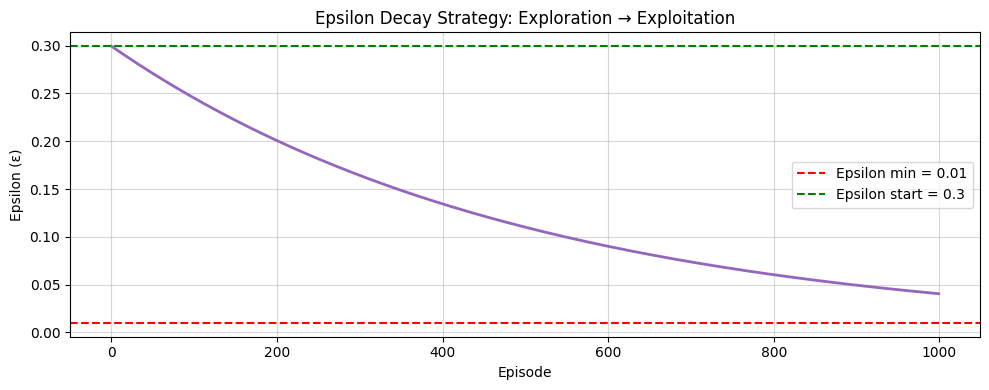

📊 Thống kê Epsilon:
   - Epsilon ban đầu: 0.2994
   - Epsilon cuối cùng: 0.0405
   - Epsilon ở episode 200: 0.2010
   - Epsilon ở episode 500: 0.1103


In [21]:
import matplotlib.pyplot as plt

# Vẽ epsilon decay curve
plt.figure(figsize=(10, 4))
plt.plot(epsilon_history, linewidth=2, color='tab:purple')
plt.axhline(y=epsilon_end, color='red', linestyle='--', label=f'Epsilon min = {epsilon_end}')
plt.axhline(y=epsilon_start, color='green', linestyle='--', label=f'Epsilon start = {epsilon_start}')
plt.xlabel('Episode')
plt.ylabel('Epsilon (ε)')
plt.title('Epsilon Decay Strategy: Exploration → Exploitation')
plt.legend()
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.show()

print(f"📊 Thống kê Epsilon:")
print(f"   - Epsilon ban đầu: {epsilon_history[0]:.4f}")
print(f"   - Epsilon cuối cùng: {epsilon_history[-1]:.4f}")
print(f"   - Epsilon ở episode 200: {epsilon_history[199]:.4f}")
print(f"   - Epsilon ở episode 500: {epsilon_history[499]:.4f}")

## 📉 Visualize Epsilon Decay Strategy

Biểu đồ này cho thấy:
- Epsilon giảm dần từ 0.3 → 0.01
- Agent khám phá nhiều ở đầu, khai thác nhiều ở cuối
- Giúp cân bằng exploration-exploitation tradeoff

## 💾 Lưu Q-table và metadata sau khi huấn luyện

Sau khi huấn luyện xong, chúng ta sẽ lưu:
- Q-table (numpy array)
- Các tham số mô hình (alpha, gamma, epsilon, v.v.)
- Thông tin training (số episodes, chi phí cuối, thời gian)

Điều này giúp:
- ✅ Không cần train lại từ đầu
- ✅ So sánh các phiên bản model khác nhau
- ✅ Triển khai production dễ dàng

In [22]:
# Trích xuất chính sách tối ưu từ Q-table
policy = np.argmax(Q, axis=1)  # chọn hành động tốt nhất ở mỗi trạng thái

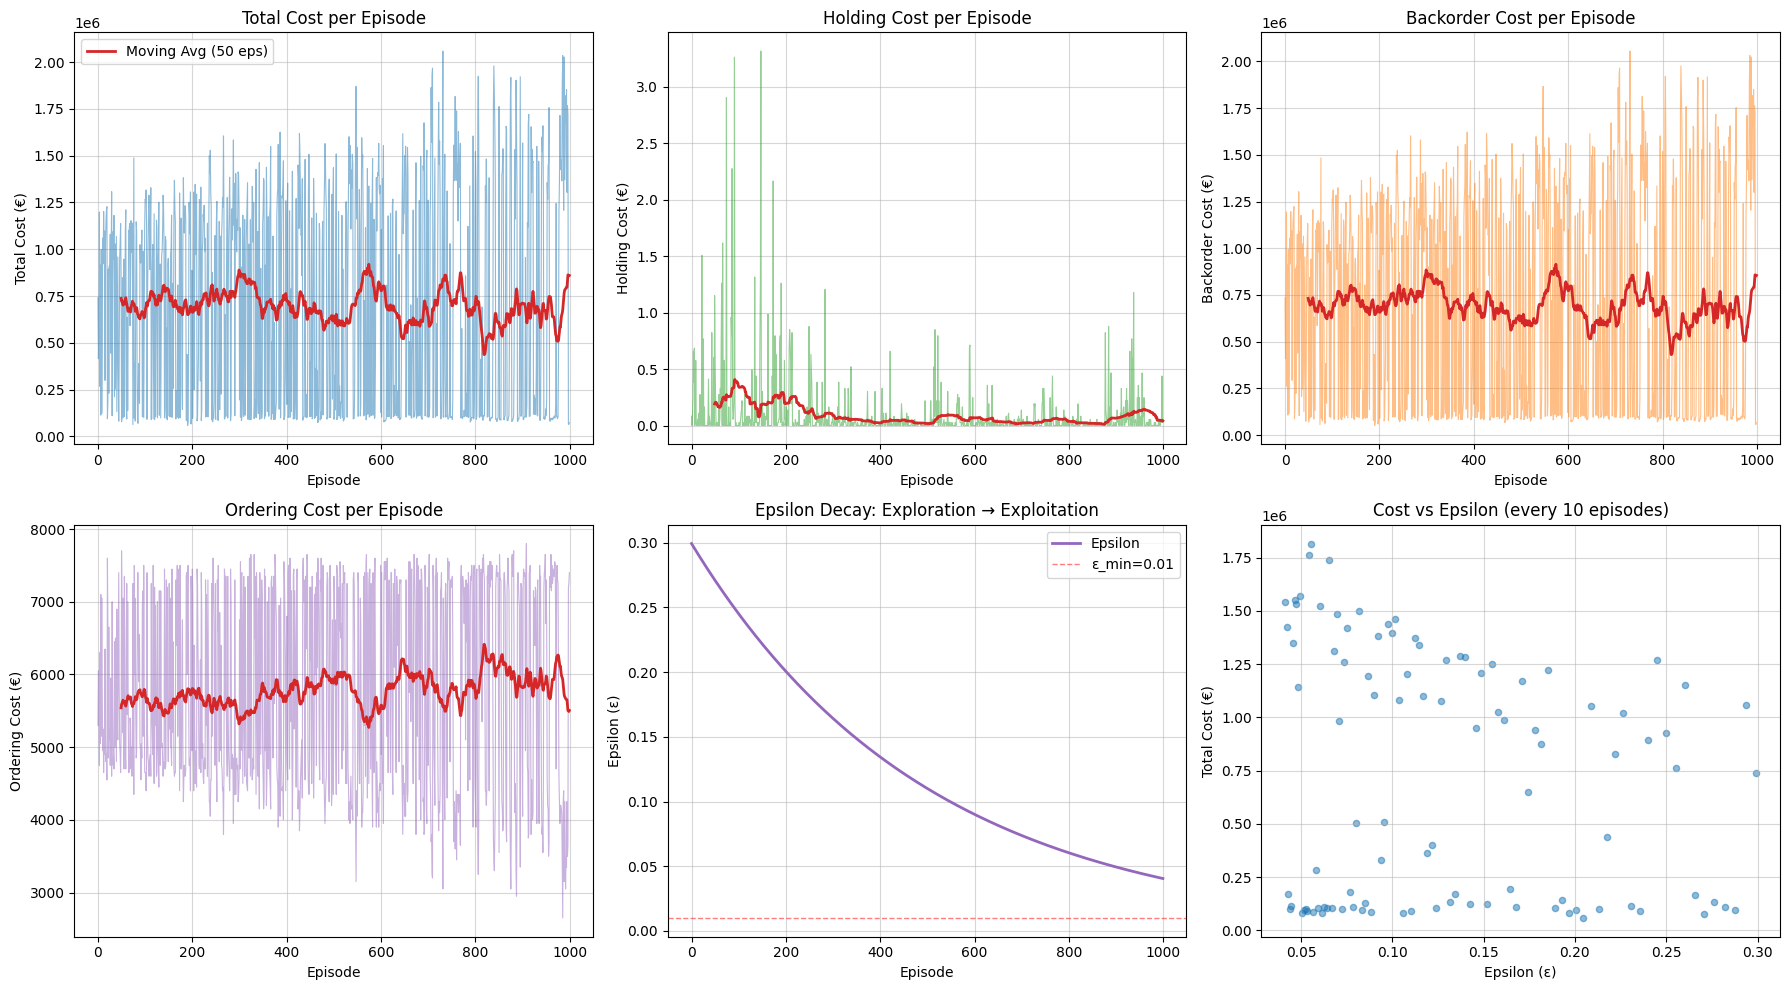


📊 Thống kê chi phí:
   - Episode đầu tiên: 740440.08 €
   - Episode cuối cùng: 73440.05 €
   - Trung bình 100 episode cuối: 757947.29 €
   - Chi phí thấp nhất: 58331.26 € (episode 191)
   - Chi phí cao nhất: 2058490.03 € (episode 732)

📈 Thống kê Epsilon:
   - Epsilon ban đầu: 0.2994
   - Epsilon cuối cùng: 0.0405
   - Giảm: 86.5%


In [23]:
import matplotlib.pyplot as plt

# Vẽ learning curve (5 biểu đồ)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Tổng chi phí theo episode
axes[0, 0].plot(episode_costs, linewidth=0.8, alpha = 0.5, color='tab:blue')
axes[0, 0].plot(pd.Series(episode_costs).rolling(50).mean(), linewidth=2, color='tab:red', label='Moving Avg (50 eps)')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Total Cost (€)')
axes[0, 0].set_title('Total Cost per Episode')
axes[0, 0].legend()
axes[0, 0].grid(alpha = 0.5)

# 2. Chi phí lưu kho
axes[0, 1].plot(episode_holding, linewidth=0.8, alpha = 0.5, color='tab:green')
axes[0, 1].plot(pd.Series(episode_holding).rolling(50).mean(), linewidth=2, color='tab:red')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Holding Cost (€)')
axes[0, 1].set_title('Holding Cost per Episode')
axes[0, 1].grid(alpha = 0.5)

# 3. Chi phí thiếu hàng
axes[0, 2].plot(episode_backorder, linewidth=0.8, alpha = 0.5, color='tab:orange')
axes[0, 2].plot(pd.Series(episode_backorder).rolling(50).mean(), linewidth=2, color='tab:red')
axes[0, 2].set_xlabel('Episode')
axes[0, 2].set_ylabel('Backorder Cost (€)')
axes[0, 2].set_title('Backorder Cost per Episode')
axes[0, 2].grid(alpha = 0.5)

# 4. Chi phí đặt hàng
axes[1, 0].plot(episode_ordering, linewidth=0.8, alpha = 0.5, color='tab:purple')
axes[1, 0].plot(pd.Series(episode_ordering).rolling(50).mean(), linewidth=2, color='tab:red')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Ordering Cost (€)')
axes[1, 0].set_title('Ordering Cost per Episode')
axes[1, 0].grid(alpha = 0.5)

# 5. 🔥 Epsilon Decay (MỚI)
axes[1, 1].plot(epsilon_history, linewidth=2, color='tab:purple', label='Epsilon')
axes[1, 1].axhline(y=epsilon_end, color='red', linestyle='--', linewidth=1, alpha = 0.5, label=f'ε_min={epsilon_end}')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon (ε)')
axes[1, 1].set_title('Epsilon Decay: Exploration → Exploitation')
axes[1, 1].legend()
axes[1, 1].grid(alpha = 0.5)

# 6. Cost vs Epsilon (correlation)
axes[1, 2].scatter(epsilon_history[::10], episode_costs[::10], alpha = 0.5, s=20, color='tab:blue')
axes[1, 2].set_xlabel('Epsilon (ε)')
axes[1, 2].set_ylabel('Total Cost (€)')
axes[1, 2].set_title('Cost vs Epsilon (every 10 episodes)')
axes[1, 2].grid(alpha = 0.5)

plt.tight_layout()
plt.show()

print(f"\n📊 Thống kê chi phí:")
print(f"   - Episode đầu tiên: {episode_costs[0]:.2f} €")
print(f"   - Episode cuối cùng: {episode_costs[-1]:.2f} €")
print(f"   - Trung bình 100 episode cuối: {np.mean(episode_costs[-100:]):.2f} €")
print(f"   - Chi phí thấp nhất: {min(episode_costs):.2f} € (episode {episode_costs.index(min(episode_costs)) + 1})")
print(f"   - Chi phí cao nhất: {max(episode_costs):.2f} € (episode {episode_costs.index(max(episode_costs)) + 1})")
print(f"\n📈 Thống kê Epsilon:")
print(f"   - Epsilon ban đầu: {epsilon_history[0]:.4f}")
print(f"   - Epsilon cuối cùng: {epsilon_history[-1]:.4f}")
print(f"   - Giảm: {(epsilon_history[0] - epsilon_history[-1]) / epsilon_history[0] * 100:.1f}%")

## 📊 Vẽ biểu đồ quá trình học (Learning Curve)

Biểu đồ này giúp quan sát:
- Model có đang học hay không?
- Chi phí có giảm dần qua các episode?
- Model đã hội tụ chưa?

In [24]:
# Mô phỏng đánh giá chính sách
def learned_policy(ip):
    """Chính sách do mô hình học được."""
    return int(policy[ip_to_index(ip)])


def rq_policy(ip):
    """Chính sách (r,q) truyền thống."""
    return 1 if ip <= r else 0


def evaluate(policy_func, days=365 * 5, seed=42):
    """Mô phỏng thực tế trong nhiều ngày để tính chi phí trung bình/ngày."""
    np.random.seed(seed)
    total_cost = 0
    ip = r
    orders_in_transit = 0
    for day in range(days):
        a = policy_func(ip)
        next_ip, _, orders_in_transit, cost = step(ip, orders_in_transit, a)
        ip = next_ip
        total_cost += cost
    return total_cost / days

In [25]:
# 🔍 KIỂM TRA Q-TABLE TRƯỚC KHI ĐÁNH GIÁ
print("=" * 60)
print("🔍 KIỂM TRA Q-TABLE")
print("=" * 60)
print(f"Q-table shape: {Q.shape}")
print(f"Q-table min: {Q.min():.2f}")
print(f"Q-table max: {Q.max():.2f}")
print(f"Q-table mean: {Q.mean():.2f}")
print(f"Số giá trị khác 0: {np.count_nonzero(Q)} / {Q.size}")
print(f"\nMẫu Q-table (5 states đầu):")
for i in range(min(5, len(states))):
    print(f"  State {states[i]:3d} (IP={states[i]:3d}): Q[{i}] = {Q[i]}")

# ⚠️ CẢNH BÁO NẾU Q-TABLE CHƯA TRAIN
if np.allclose(Q, 0):
    print("\n" + "="*60)
    print("⚠️  CẢNH BÁO: Q-TABLE TOÀN SỐ 0!")
    print("="*60)
    print("❌ Bạn đã SKIP cell training (Cell 7)!")
    print("❌ Agent chưa học gì cả → kết quả vô nghĩa")
    print("\n✅ GIẢI PHÁP:")
    print("   1. Quay lại Cell 7")
    print("   2. Chạy training để cập nhật Q-table")
    print("   3. Hoặc load model đã train: USE_PRETRAINED = True")
    print("="*60)
    print()

# Đánh giá chính sách học được
print("\n" + "="*60)
print("📊 ĐÁNH GIÁ PERFORMANCE")
print("="*60)

learned_cost = evaluate(learned_policy)
rq_cost = evaluate(rq_policy)

# Tính reduction (dương = tốt hơn, âm = tệ hơn)
reduction = (rq_cost - learned_cost) / rq_cost * 100

print(f"\nKết quả so sánh:")
print(f" - Chính sách học được:      {learned_cost:10.2f} €/ngày")
print(f" - Chính sách (r,q) truyền thống: {rq_cost:10.2f} €/ngày")
print(f" - Chênh lệch:               {learned_cost - rq_cost:10.2f} €/ngày")

if reduction > 0:
    print(f" - ✅ Cải thiện:             {reduction:10.2f}%")
    print(f"\n🎉 AGENT HỌC TỐT! Chi phí giảm {reduction:.1f}%")
elif reduction > -5:
    print(f" - ⚠️  Tệ hơn:               {abs(reduction):10.2f}%")
    print(f"\n⚠️  Agent học chưa tốt, cần train thêm hoặc tune hyperparameters")
else:
    print(f" - ❌ TỆ HƠN:                {abs(reduction):10.2f}%")
    print(f"\n🚨 AGENT HỌC SAI! Chi phí cao hơn {abs(reduction):.0f}%")
    print("\n🔍 Nguyên nhân có thể:")
    print("   1. Q-table chưa được train (kiểm tra ở trên)")
    print("   2. Alpha/gamma không phù hợp")
    print("   3. Chưa đủ episodes để hội tụ")
    print("   4. Reward function sai")

print("="*60)

🔍 KIỂM TRA Q-TABLE
Q-table shape: (41, 2)
Q-table min: -9852.95
Q-table max: 0.00
Q-table mean: -688.89
Số giá trị khác 0: 81 / 82

Mẫu Q-table (5 states đầu):
  State -20 (IP=-20): Q[0] = [-9852.95394342  -847.60327106]
  State -19 (IP=-19): Q[1] = [-1141.25399156 -8978.96813492]
  State -18 (IP=-18): Q[2] = [-7125.8859914   -670.96594354]
  State -17 (IP=-17): Q[3] = [-3628.29821978  -617.0635689 ]
  State -16 (IP=-16): Q[4] = [ -516.4093212 -3748.2315999]

📊 ĐÁNH GIÁ PERFORMANCE

Kết quả so sánh:
 - Chính sách học được:          243.40 €/ngày
 - Chính sách (r,q) truyền thống:      30.60 €/ngày
 - Chênh lệch:                   212.80 €/ngày
 - ❌ TỆ HƠN:                    695.43%

🚨 AGENT HỌC SAI! Chi phí cao hơn 695%

🔍 Nguyên nhân có thể:
   1. Q-table chưa được train (kiểm tra ở trên)
   2. Alpha/gamma không phù hợp
   3. Chưa đủ episodes để hội tụ
   4. Reward function sai


In [26]:
# Hiển thị chính sách học được
policy_df = pd.DataFrame({
    "inventory_position": states,
    "action (0=no order,1=order)": policy
})

print("\n Một phần của chính sách học được:")
print(policy_df)


 Một phần của chính sách học được:
    inventory_position  action (0=no order,1=order)
0                  -20                            1
1                  -19                            0
2                  -18                            1
3                  -17                            1
4                  -16                            0
5                  -15                            0
6                  -14                            1
7                  -13                            1
8                  -12                            1
9                  -11                            0
10                 -10                            1
11                  -9                            0
12                  -8                            0
13                  -7                            1
14                  -6                            0
15                  -5                            0
16                  -4                            0
17                  -3      

In [27]:
# ===============================================================
# Mô phỏng 30 ngày – đầy đủ các biến để quan sát (giống bài báo)
# ===============================================================
np.random.seed(123)
days = np.arange(1, 31)  # mô phỏng 30 ngày
ip = r
orders_in_transit = 0
records = []

for day in days:
    a = learned_policy(ip)   # hành động theo chính sách đã học
    d = sample_demand()      # nhu cầu ngẫu nhiên mỗi ngày
    arrivals = 0

    # Nếu hôm nay có hàng về (lead time = 1)
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    inventory_before = ip
    ip_after = ip + arrivals - d

    # Nếu hôm nay đặt hàng, hàng sẽ đến ngày sau
    if a == 1:
        orders_in_transit = q

    # 🔹 Tính chi phí hằng ngày
    holding_cost = h * max(ip_after, 0)
    backorder_cost = b * max(-ip_after, 0)
    ordering_cost = O if a == 1 else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # Ghi lại dữ liệu từng ngày
    records.append({
        "day": day,
        "demand": d,
        "inventory_before": inventory_before,
        "order_action": a,
        "arrivals_today": arrivals,
        "inventory_after": ip_after,
        "daily_cost": total_cost
    })

    ip = ip_after

# 🔸 Tạo DataFrame kết quả
df_sim = pd.DataFrame(records)
print("\nDữ liệu mô phỏng 30 ngày đầu:")
print(df_sim.to_string(index=False))


Dữ liệu mô phỏng 30 ngày đầu:
 day  demand  inventory_before  order_action  arrivals_today  inventory_after  daily_cost
   1       2                 3             0               0                1    0.027397
   2       4                 1             0               0               -3   60.000000
   3       3                -3             1               0               -6  170.000000
   4       1                -6             0               6               -1   20.000000
   5       2                -1             1               0               -3  110.000000
   6       5                -3             1               6               -2   90.000000
   7       1                -2             0               6                3    0.082192
   8       3                 3             0               0                0    0.000000
   9       4                 0             0               0               -4   80.000000
  10       2                -4             0               0         

In [28]:
import matplotlib.pyplot as plt

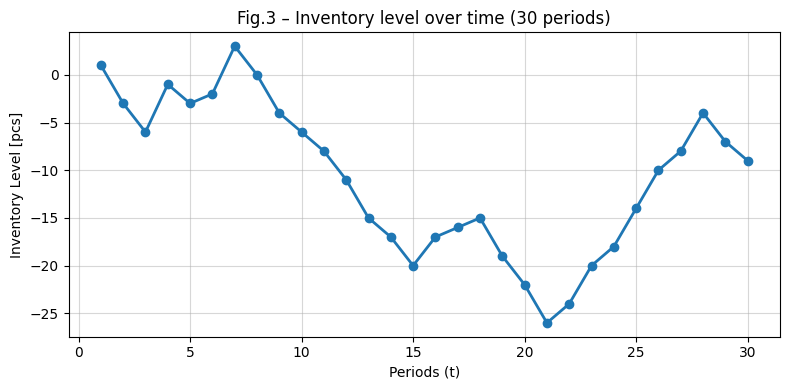

In [29]:
# ===============================================================
# Fig.3 – Inventory Level (Pcs)
# ===============================================================
plt.figure(figsize=(8,4))
plt.plot(df_sim["day"], df_sim["inventory_after"], marker='o', color='tab:blue', linewidth=2)
plt.xlabel("Periods (t)")
plt.ylabel("Inventory Level [pcs]")
plt.title("Fig.3 – Inventory level over time (30 periods)")
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.show()

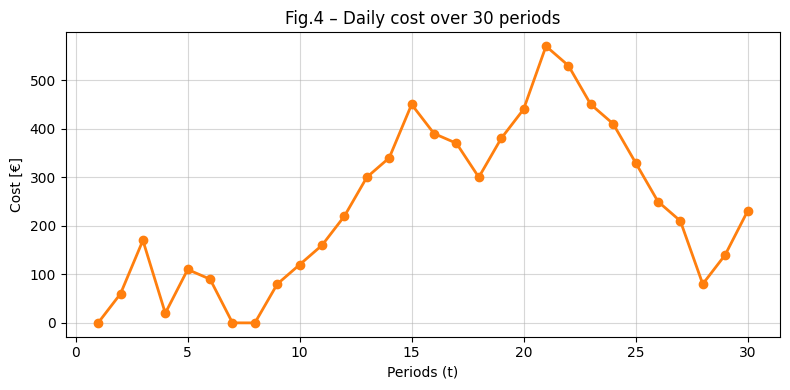

In [30]:
# ===============================================================
#  Fig.4 – Cost (€)
# ===============================================================
plt.figure(figsize=(8,4))
plt.plot(df_sim["day"], df_sim["daily_cost"], marker='o', color='tab:orange', linewidth=2)
plt.xlabel("Periods (t)")
plt.ylabel("Cost [€]")
plt.title("Fig.4 – Daily cost over 30 periods")
plt.grid(alpha = 0.5)
plt.tight_layout()
plt.show()

In [31]:
# 🔍 DEBUG: Check Q-values quanh reorder point r=3
print("Q-values around reorder point r=3:")
print("IP | Q[no_order] | Q[order] | Best Action")
print("-" * 60)
for ip in range(-5, 10):
    idx = ip_to_index(ip)  # ip + 20
    q0, q1 = Q[idx]
    best = "ORDER" if np.argmax([q0, q1]) == 1 else "NO_ORDER"
    marker = " ← (r,q) orders here" if ip == 3 else ""
    print(f"{ip:3d} | {q0:12.2f} | {q1:11.2f} | {best:9s}{marker}")

Q-values around reorder point r=3:
IP | Q[no_order] | Q[order] | Best Action
------------------------------------------------------------
 -5 |      -317.10 |     -388.16 | NO_ORDER 
 -4 |      -289.05 |     -412.93 | NO_ORDER 
 -3 |      -332.04 |     -329.17 | ORDER    
 -2 |      -215.59 |     -331.65 | NO_ORDER 
 -1 |      -326.59 |     -257.24 | ORDER    
  0 |      -164.27 |     -228.06 | NO_ORDER 
  1 |      -138.43 |     -211.71 | NO_ORDER 
  2 |      -129.57 |     -197.41 | NO_ORDER 
  3 |      -131.01 |     -158.97 | NO_ORDER  ← (r,q) orders here
  4 |       -91.73 |     -123.17 | NO_ORDER 
  5 |       -52.58 |      -96.06 | NO_ORDER 
  6 |       -33.11 |      -86.95 | NO_ORDER 
  7 |       -27.72 |      -64.34 | NO_ORDER 
  8 |       -20.52 |      -67.00 | NO_ORDER 
  9 |       -19.35 |      -55.34 | NO_ORDER 
